# Redes Neuronales Recurrentes (RNN)
## Alumno: Diego Alexander Watko Zerecero


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Cargar los datos de entrenamiento
train_data = pd.read_csv('tortilla_prices.csv')

# Crear columna de fecha a partir de Year, Month y Day
train_data['Date'] = pd.to_datetime(train_data[['Year', 'Month', 'Day']])

# Eliminar columnas Year, Month y Day
train_data = train_data.drop(['Year', 'Month', 'Day'], axis=1)

# Establecer Date como índice
train_data = train_data.set_index('Date')

train_data_or = train_data[train_data['State'] == 'Jalisco'][['Price per kilogram']]

# Limpieza de datos
train_data_or.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)

# Convertir el dato a float para poder interpolar
train_data_or = train_data_or.astype(float)

# Eliminar filas con NaN antes del agrupado
train_data_or.dropna(subset=['Price per kilogram'], inplace=True)

# Agrupar por día (en caso de múltiples registros el mismo día)
train_data_or = train_data_or.groupby(train_data_or.index).mean()

# Reindexar para garantizar frecuencia diaria (evitar huecos en el calendario)
full_date_range = pd.date_range(start=train_data_or.index.min(),
                                end=train_data_or.index.max(),
                                freq='D')
train_data_or = train_data_or.reindex(full_date_range)
train_data_or.index.name = 'Date'  # nombramos el índice como 'Date'

# Interpolación lineal entre puntos previos y posteriores
train_data_or = train_data_or.interpolate(method='linear')

# FILTRAR solo hasta diciembre 2023
train_data_train = train_data_or[train_data_or.index < '2024-01-01']

train_data_train

,Price per kilogram
Date,
2007-01-10,7.465
2007-01-11,7.565
2007-01-12,7.665
2007-01-13,7.665
2007-01-14,7.665
...,...
2023-12-27,19.325
2023-12-28,19.325
2023-12-29,19.325


In [16]:
# Escalado de datos  
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data_train)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=90):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 90)


In [24]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


C:\Users\diego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



# Optimizador
Se utilizó una red LSTM entrenada con el optimizador Adam porque la tarea involucra series de tiempo con dependencias de largo plazo y comportamientos no lineales, para lo cual las puertas de memoria de la LSTM son adecuadas; y Adam ofrece un ajuste adaptativo de la tasa de aprendizaje, integrando momentum y normalización del gradiente, lo que facilita la convergencia estable en redes recurrentes. Se partió de un learning‑rate de 0.001 y se ajustó empíricamente en validación. Otras opciones (RMSprop, GRU, ARIMA) se consideraron como líneas base, pero la LSTM con Adam mostró mejor capacidad de generalización y menor error cuadrático medio en los datos que usamos el optimizador Adam ya que ajusta una tasa de aprendizaje diferente para cada parámetro a partir de las primeras y segundas derivadas (momentos) del gradiente. Esto acelera la convergencia en problemas donde la magnitud de los gradientes varía mucho, como ocurre en RNN/LSTM, además tolera bien el reescalado de datos como el Min-Max a $[0, 1]$ que usamos, y al trabajar con una serie de tiempo, Adam ofrece estabilidad con gradientes largos y cortos.

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0130
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.9154e-04
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.9600e-04
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 1.9517e-04
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1.6611e-04
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.6965e-04
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 1.5151e-04
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 2.3414e-04
Epoch 9/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 1.3994e-04
Epoch 10/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 1.2055e-04
Epoch 11/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 1.0934e-04
Epoch 12/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 1.4596e-04
Epoch 13/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 1.5607e-04
Epoch 14/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/s

In [27]:
# Cargar nuevamente los datos
real_data_2024 = pd.read_csv('tortilla_prices.csv')

# Crear columna de fecha
real_data_2024['Date'] = pd.to_datetime(real_data_2024[['Year', 'Month', 'Day']])

# Eliminar columnas innecesarias
real_data_2024 = real_data_2024.drop(['Year', 'Month', 'Day'], axis=1)

# Establecer índice
real_data_2024 = real_data_2024.set_index('Date')

# Filtrar solo Durango en 2024
real_data_2024 = real_data_2024[
    (real_data_2024['State'] == 'Jalisco') & (real_data_2024.index >= '2024-01-01')
]

# Quedarse solo con la columna de precio
real_data_2024 = real_data_2024[['Price per kilogram']]

# Reemplazar valores que indican faltantes
real_data_2024.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)

# Convertir a float
real_data_2024 = real_data_2024.astype(float)

# Eliminar filas con NaN antes de agrupar (para no promediar nulos)
real_data_2024.dropna(subset=['Price per kilogram'], inplace=True)

# Agrupar por día (por si hay duplicados en la misma fecha)
real_data_2024 = real_data_2024.groupby(real_data_2024.index).mean()

# Reindexar para forzar frecuencia diaria (y rellenar días sin observaciones)
full_date_range_2024 = pd.date_range(
    start=real_data_2024.index.min(),
    end=real_data_2024.index.max(),
    freq='D'
)
real_data_2024 = real_data_2024.reindex(full_date_range_2024)
real_data_2024.index.name = 'Date'

# Interpolación lineal para valores NaN
real_data_2024 = real_data_2024.interpolate(method='linear')

# Escalar con el MISMO scaler usado en el entrenamiento
real_scaled = scaler.transform(real_data_2024)

# Ahora 'real_scaled' es un array NumPy escalado (N, 1)
# y 'real_data_2024' es el DataFrame con índice diario y sin huecos

real_data_2024

,Price per kilogram
Date,
2024-01-03,19.325000
2024-01-04,19.325000
2024-01-05,19.325000
2024-01-06,19.330833
2024-01-07,19.336667
...,...
2024-10-17,19.667500
2024-10-18,19.667500
2024-10-19,19.667500


In [28]:
# Crear las secuencias de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-90:], real_scaled]), 90)

# Hacer predicciones
predictions_scaled = model.predict(X_real)

# Invertir el escalado para obtener precios reales
predictions = scaler.inverse_transform(predictions_scaled)

# Invertir escala de datos reales también
real_demand = scaler.inverse_transform(real_scaled)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


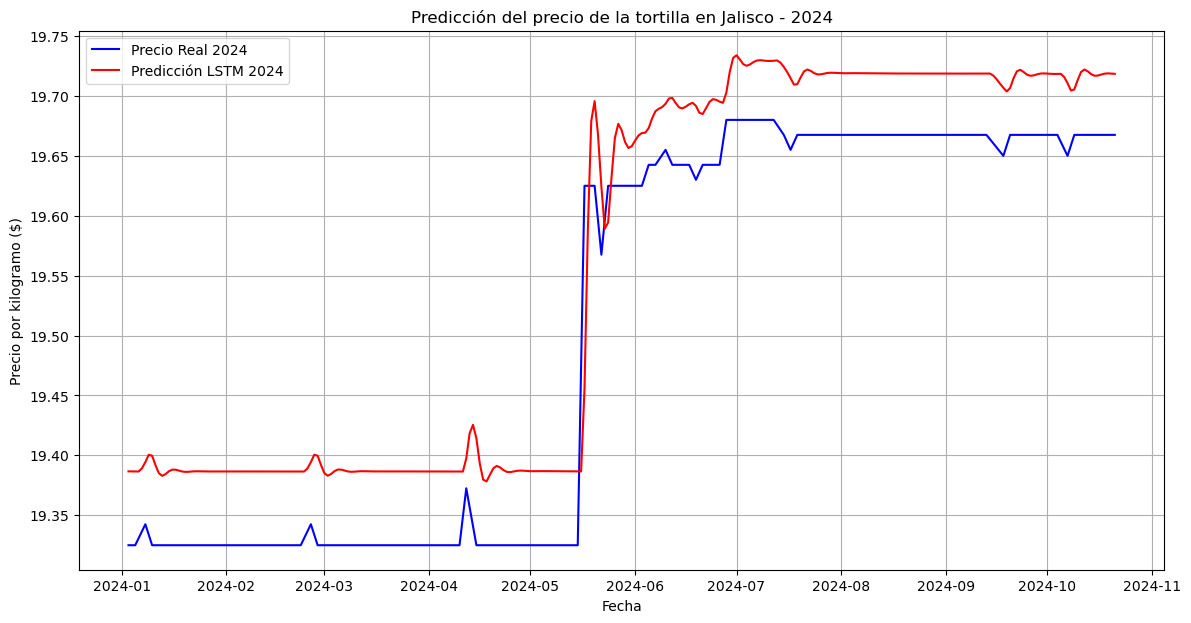

In [29]:

# Graficar comparación entre precios reales y predicciones
plt.figure(figsize=(14, 7))
plt.plot(real_data_2024.index[:len(real_demand)], real_demand, label='Precio Real 2024', color='blue')
plt.plot(real_data_2024.index[:len(predictions)], predictions, label='Predicción LSTM 2024', color='red')
plt.title('Predicción del precio de la tortilla en Jalisco - 2024')
plt.xlabel('Fecha')
plt.ylabel('Precio por kilogramo ($)')
plt.legend()
plt.grid(True)
plt.show()


R² para el mes 1: -224.5599
R² para el mes 2: -225.2547
R² para el mes 3: -74921031791190950520291328.0000
R² para el mes 4: -31.2180
R² para el mes 5: 0.8105
R² para el mes 6: -9.9346
R² para el mes 7: -50.2027
R² para el mes 8: -208403818131887359755550720.0000
R² para el mes 9: -126.0358
R² para el mes 10: -119.1777


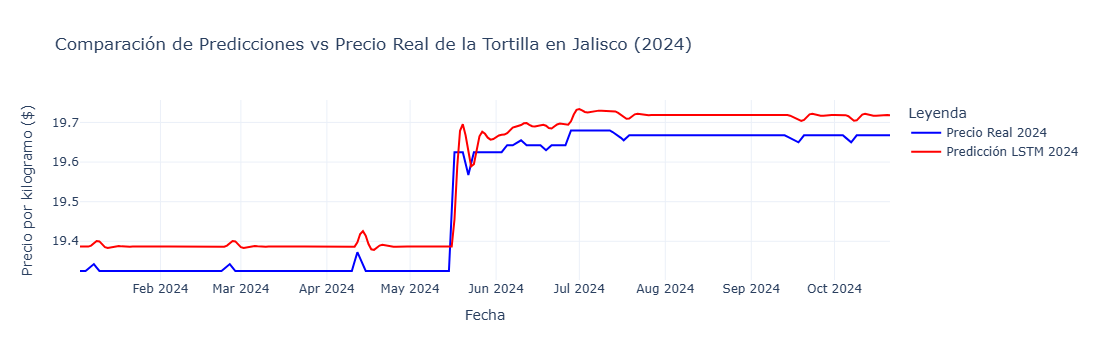

In [30]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurar que longitudes y fechas coincidan
real_demand = pd.Series(real_demand[:len(predictions)].flatten(), index=real_data_2024.index[:len(predictions)])

predictions_series = pd.Series(predictions.flatten(), index=real_data_2024.index[:len(predictions)])

# Calcular R² mensual
r_squared_monthly = []

for month, group in real_demand.groupby(real_demand.index.month):
    pred_for_month = predictions_series[group.index]
    r_squared = r2_score(group, pred_for_month)
    r_squared_monthly.append((month, r_squared))
    print(f'R² para el mes {month}: {r_squared:.4f}')

# Gráfica interactiva con Plotly
fig = go.Figure()

# Línea azul: precios reales
fig.add_trace(go.Scatter(
    x=real_demand.index, y=real_demand, mode='lines', name='Precio Real 2024', line=dict(color='blue')
))

# Línea roja: predicciones del modelo
fig.add_trace(go.Scatter(
    x=predictions_series.index, y=predictions_series, mode='lines', name='Predicción LSTM 2024', line=dict(color='red')
))

# Personalización del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Precio Real de la Tortilla en Jalisco (2024)',
    xaxis_title='Fecha',
    yaxis_title='Precio por kilogramo ($)',
    legend_title='Leyenda',
    template='plotly_white'
)

fig.show()
